# TOLIMAN++ Feasibility

The purpose of this notebook is to determine the amount of photons detected as a function of FOV around two target stars, $\tau$-Ceti and $\varepsilon$-Eridani. 

Currently, this uses two star catalogues to achieve this: 
 - GAIA data release 3
 - The Bright Star Catalogue (BSC, aka BSC5P)
 
 The GAIA dataset is used to determine the background stars of magnitudes 6.5-20 ish. The BSC is used for the bright stars of magnitude <6.5. 
 
A current limitation is that the BSC only covers a slice of the sky from a right ascension of 0-25 degrees. As both $\tau$-Ceti and $\varepsilon$-Eridani, have a low positive single digit RA, the FOV radii range considered is ~1.75 degrees for $\tau$-Ceti and ~3.5 $\varepsilon$-Eridani. **Future work** includes expanding this range by including more star catalogues.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy
import tqdm.notebook as tqdm
import pandas as pd

import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
from astroquery.gaia import Gaia

## Location of Target Stars

In [2]:
# Tau Ceti
TC_ra = astropy.coordinates.Angle('1d44m04.08338s') # from wikipedia
TC_dec = astropy.coordinates.Angle('-15d56m14.9262s') #from wikipedia

# Epsilon Eridani
EE_ra = astropy.coordinates.Angle('3d32m55.84496s') # from wikipedia
EE_dec = astropy.coordinates.Angle('-9d27m29.7312s') # from wikipedia


# Load in and clean data (GAIA)

In [3]:
tables = Gaia.load_tables(only_names=True)
#for table in (tables):
#    print (table.get_qualified_name())

INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]


The following 3 cells take over 5 mins in total to execute. Main cause of the data is retrieving and loading the data from the GAIA servers.

In [4]:
%%time
TC_job = Gaia.launch_job_async("SELECT * \
FROM gaiadr3.gaia_source \
WHERE CONTAINS(POINT('ICRS',gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),CIRCLE('ICRS',{},{},{}))=1;".format(TC_ra.degree, TC_dec.degree, TC_ra.degree) \
, dump_to_file=True)

EE_job = Gaia.launch_job_async("SELECT * \
FROM gaiadr3.gaia_source \
WHERE CONTAINS(POINT('ICRS',gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),CIRCLE('ICRS',{},{},{}))=1;".format(EE_ra.degree, EE_dec.degree, EE_ra.degree) \
, dump_to_file=True)

CPU times: user 512 ms, sys: 160 ms, total: 672 ms
Wall time: 3min 35s


In [5]:
%%time
TC_results = TC_job.get_results()
EE_results = EE_job.get_results()

CPU times: user 2min 24s, sys: 416 ms, total: 2min 24s
Wall time: 2min 24s


In [6]:
# remove duplicates
TC_results = TC_results[TC_results['duplicated_source'] == False]
EE_results = EE_results[EE_results['duplicated_source'] == False]

# remove stars covered in the BSC
TC_results = TC_results[TC_results['phot_g_mean_mag'] > 6.5]
EE_results = EE_results[EE_results['phot_g_mean_mag'] > 6.5]

print('There are {} unique GAIA stars within a {:.3f} degree radius of {}.'.format(np.shape(TC_results)[0], TC_ra.degree, 'Tau Ceti'))
print('There are {} unique GAIA stars within a {:.3f} degree radius of {}.'.format(np.shape(EE_results)[0], EE_ra.degree, 'Epsilon Eridani'))

There are 30478 unique GAIA stars within a 1.734 degree radius of Tau Ceti.
There are 117697 unique GAIA stars within a 3.549 degree radius of Epsilon Eridani.


Following is just scaling to deal with plotting nicely

In [7]:
scaled_RA = TC_results['ra']*np.pi/180
scaled_DEC = TC_results['dec']*np.pi/180

for i in tqdm.tqdm(range(len(scaled_RA))):
    if scaled_RA[i] > np.pi:
        scaled_RA[i] = scaled_RA[i] - 2*np.pi
    if scaled_DEC[i] > np.pi:
        scaled_DEC[i] = scaled_DEC[i] - 2*np.pi
        
TC_area_ra = scaled_RA
TC_area_dec = scaled_DEC

scaled_RA = EE_results['ra']*np.pi/180
scaled_DEC = EE_results['dec']*np.pi/180

for i in tqdm.tqdm(range(len(scaled_RA))):
    if scaled_RA[i] > np.pi:
        scaled_RA[i] = scaled_RA[i] - 2*np.pi
    if scaled_DEC[i] > np.pi:
        scaled_DEC[i] = scaled_DEC[i] - 2*np.pi
        
EE_area_ra = scaled_RA
EE_area_dec = scaled_DEC

TC_mags = TC_results['phot_g_mean_mag']
EE_mags = EE_results['phot_g_mean_mag']

  0%|          | 0/30478 [00:00<?, ?it/s]

  0%|          | 0/117697 [00:00<?, ?it/s]

# Load in and clean data (BSC)
**Note**: dataset is poorly labelled - col names are actually a row. Proper col names are: index(?) Name, RA, DEC, MAG

In [8]:
BSC = pd.read_csv('bscmag65.csv')
named = BSC.dropna()

# cleans array 
arr = BSC.to_numpy()
new_arr = arr[:,2:]
newer_arr = np.zeros(np.shape(new_arr))

for i in tqdm.tqdm(range(len(new_arr))):
    RA = new_arr[i,0].split(':')
    RA_deg = float(RA[0])
    RA_min = float(RA[1])
    RA_sign = np.sign(RA_deg)
    if RA_sign == -1:
        RA_decimal = RA_deg + (1/60) * RA_min*(-1)
    else:
        RA_decimal = RA_deg + (1/60) * RA_min
    
    DEC = new_arr[i,1].split(':')
    DEC_deg = float(DEC[0])
    DEC_min = float(DEC[1])
    DEC_sign = np.sign(DEC_deg)
    if DEC_sign == -1:
        DEC_decimal = DEC_deg + (1/60) * DEC_min*(-1)
    else:
        DEC_decimal = DEC_deg + (1/60) * DEC_min    
        
    if np.isnan(new_arr[i,2]) == True:
        continue
    
    newer_arr[i,:] = [RA_decimal, DEC_decimal, new_arr[i,2]]
        
    
BSC_clean = newer_arr
Scaled_BSC_clean = BSC_clean
Scaled_BSC_clean[:,:2] = Scaled_BSC_clean[:,:2]*np.pi/180


  0%|          | 0/9110 [00:00<?, ?it/s]

# Visualising data
Most of the code has been hidden as it is just plotting code.

Text(0.5, 1.0, 'Cartesian projection of GAIA data')

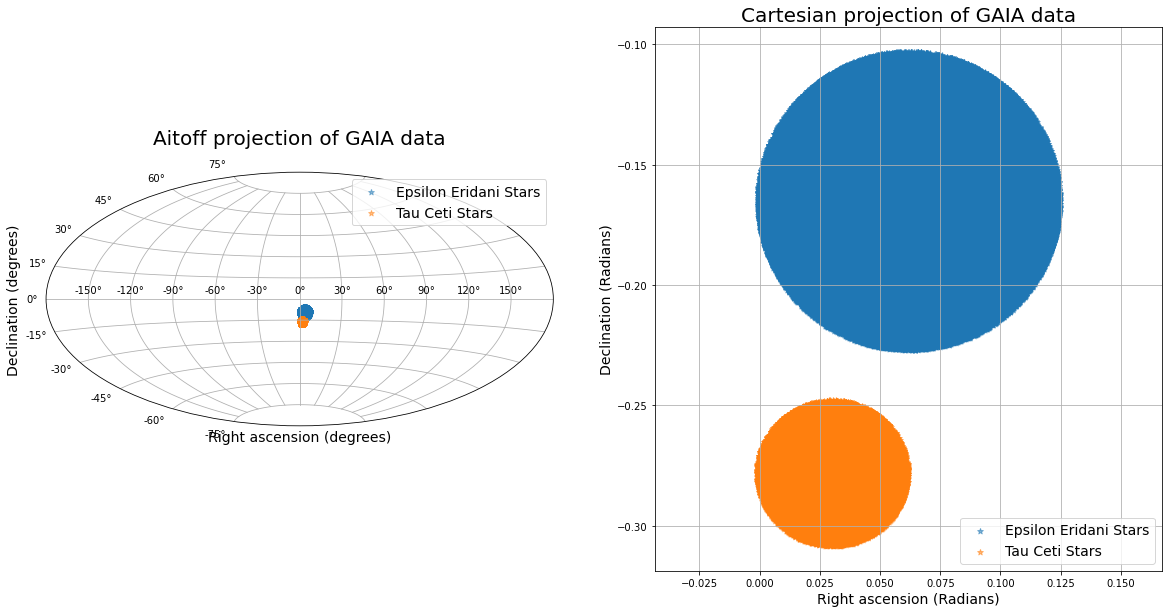

In [9]:
plt.figure(figsize = (20,10))
plt.subplot(1,2,1, projection = 'aitoff')
plt.scatter(EE_area_ra, EE_area_dec, marker = '*', alpha = 0.5, label = 'Epsilon Eridani Stars')
plt.scatter(TC_area_ra, TC_area_dec, marker = '*', alpha = 0.5, label = 'Tau Ceti Stars')
plt.legend(fontsize = 14)
plt.grid(True)
plt.xlabel('Right ascension (degrees)', fontsize = 14)
plt.ylabel('Declination (degrees)', fontsize = 14)
plt.title('Aitoff projection of GAIA data\n', fontsize = 20)

plt.subplot(1,2,2)
plt.scatter(EE_area_ra, EE_area_dec, marker = '*', alpha = 0.55, label = 'Epsilon Eridani Stars')
plt.scatter(TC_area_ra, TC_area_dec, marker = '*', alpha = 0.55, label = 'Tau Ceti Stars')
plt.legend(fontsize = 14)
plt.grid(True)
plt.xlabel('Right ascension (Radians)', fontsize = 14)
plt.ylabel('Declination (Radians)', fontsize = 14)
plt.axis('equal')
plt.title('Cartesian projection of GAIA data', fontsize = 20)

Note that above the GAIA data goes slightly over into negative right ascension (left ascension?). This is negligable for now.

(-0.30841898824243225, -0.10321113924584684)

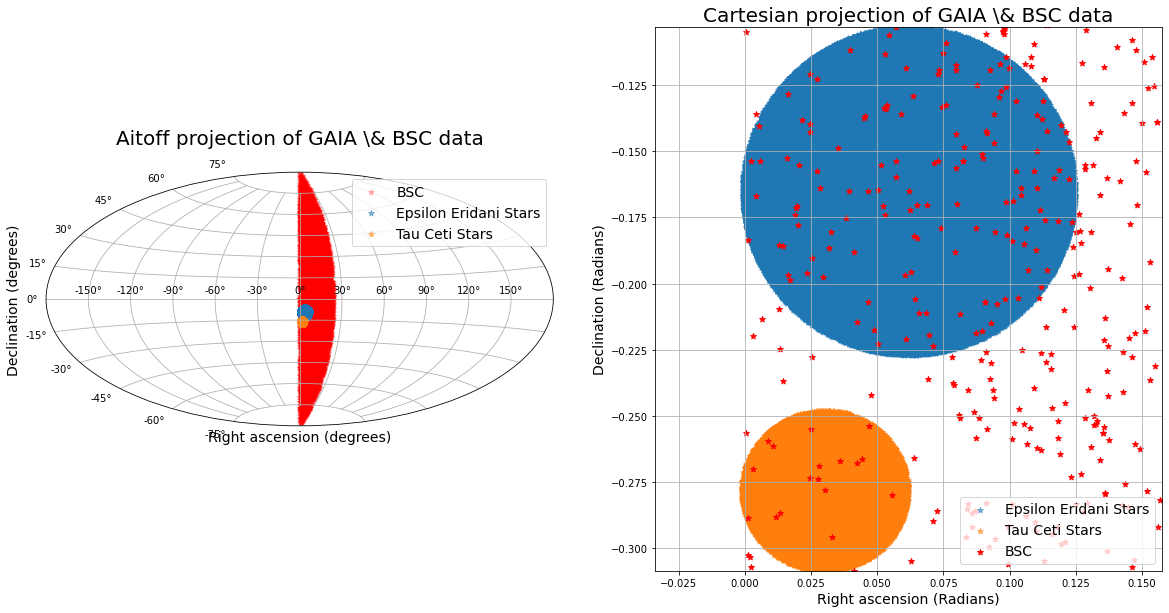

In [10]:
plt.figure(figsize = (20,10))
plt.subplot(1,2,1, projection = 'aitoff')
plt.scatter(BSC_clean[:,0], BSC_clean[:,1], alpha = 0.25, marker = '*', color = 'r', label = 'BSC')
plt.scatter(EE_area_ra, EE_area_dec, marker = '*', alpha = 0.5, label = 'Epsilon Eridani Stars')
plt.scatter(TC_area_ra, TC_area_dec, marker = '*', alpha = 0.5, label = 'Tau Ceti Stars')
plt.legend(fontsize = 14)
plt.grid(True)
plt.xlabel('Right ascension (degrees)', fontsize = 14)
plt.ylabel('Declination (degrees)', fontsize = 14)
plt.title('Aitoff projection of GAIA \& BSC data\n', fontsize = 20)

plt.subplot(1,2,2)
plt.scatter(EE_area_ra, EE_area_dec, marker = '*', alpha = 0.55, label = 'Epsilon Eridani Stars')
plt.scatter(TC_area_ra, TC_area_dec, marker = '*', alpha = 0.55, label = 'Tau Ceti Stars')
plt.scatter(BSC_clean[:,0], BSC_clean[:,1], alpha = 1, marker = '*', color = 'r', label = 'BSC')
plt.legend(fontsize = 14)
plt.grid(True)
plt.xlabel('Right ascension (Radians)', fontsize = 14)
plt.ylabel('Declination (Radians)', fontsize = 14)
plt.axis('equal')
plt.title('Cartesian projection of GAIA \& BSC data', fontsize = 20)
plt.xlim([np.min(TC_area_ra), np.max(EE_area_ra)])
plt.ylim([np.min(TC_area_dec), np.max(EE_area_dec)])

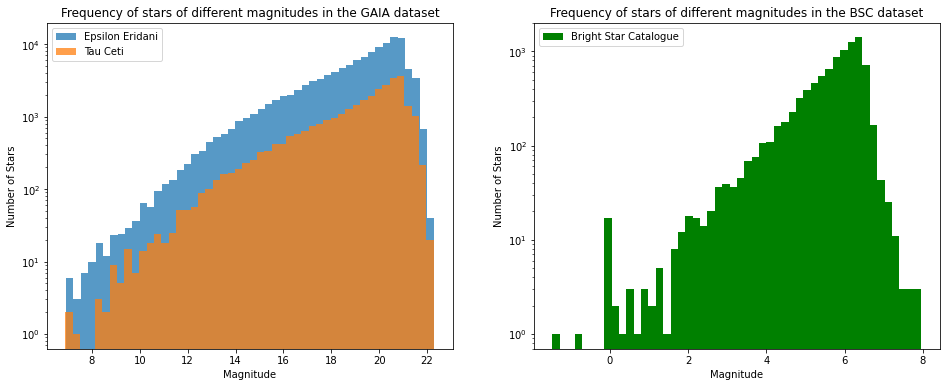

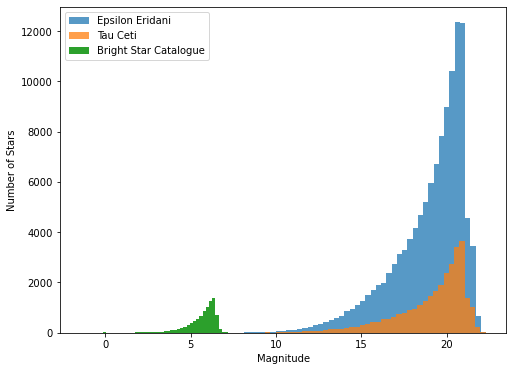

In [11]:
plt.figure(figsize = (16,6))

plt.subplot(1,2,1)
plt.hist(EE_mags, bins = 50, alpha = 0.75, label = 'Epsilon Eridani')
plt.hist(TC_mags, bins = 50, alpha = 0.75, label = 'Tau Ceti')

plt.yscale('log')
plt.xlabel('Magnitude')
plt.ylabel('Number of Stars')
plt.legend()
plt.title('Frequency of stars of different magnitudes in the GAIA dataset')

plt.subplot(1,2,2)
plt.hist(BSC_clean[:,2], bins = 50, label = 'Bright Star Catalogue', color = 'green')
plt.xlabel('Magnitude')
plt.ylabel('Number of Stars')
plt.legend()
plt.title('Frequency of stars of different magnitudes in the BSC dataset')
plt.yscale('log')

plt.figure(figsize = (8,6))
plt.hist(EE_mags, bins = 50, alpha = 0.75, label = 'Epsilon Eridani')
plt.hist(TC_mags, bins = 50, alpha = 0.75, label = 'Tau Ceti')
plt.hist(BSC_clean[:,2], bins = 50, label = 'Bright Star Catalogue')
plt.xlabel('Magnitude')
plt.ylabel('Number of Stars')
plt.legend()

Note that the apparent spike of bright stars is misleading - the BSC covers a much larger section of sky than the GAIA subsets we have obtained thus far.

# Calculations

In [12]:
def get_mags(RA, DEC, radius, star = 'TC', background = True):
    '''
    Takes the RA and DEC of a star and returns a list of all the magnitudes of stars within a radius of that point.
    All units are decimal degrees of radians (check this lol)
    '''
    if star == 'TC':
        ## Calc distance
        BSC_dist = np.sqrt((Scaled_BSC_clean[:,0] - RA)**2 + (Scaled_BSC_clean[:,1] - DEC)**2)
        GAIA_dist = np.sqrt((TC_area_ra - RA)**2 + (TC_area_dec - DEC)**2)

        ## Discard stars outside range
        BSC_mags = Scaled_BSC_clean[:,2][BSC_dist < radius] # keep corresponding mags
        GAIA_mags = np.array(TC_results['phot_g_mean_mag'])[GAIA_dist < radius] # keep corresponding mags

        ## Construct output array
        if background == True:
            output = np.concatenate((BSC_mags, GAIA_mags))
            return output
        else:
            output = BSC_mags
            return output
    
    if star == 'EE':
        ## Calc distance
        BSC_dist = np.sqrt((Scaled_BSC_clean[:,0] - RA)**2 + (Scaled_BSC_clean[:,1] - DEC)**2)
        GAIA_dist = np.sqrt((EE_area_ra - RA)**2 + (EE_area_dec - DEC)**2)

        ## Discard stars outside range
        BSC_mags = Scaled_BSC_clean[:,2][BSC_dist < radius] # keep corresponding mags
        GAIA_mags = np.array(EE_results['phot_g_mean_mag'])[GAIA_dist < radius] # keep corresponding mags

        ## Construct output array
        if background == True:
            output = np.concatenate((BSC_mags, GAIA_mags))
            return output
        else:
            output = BSC_mags
            return output
    
    else:
        print('Error: Choose either TC or EE for star selection.')

The following function converts between magnitude and electrons per second based on the conversion in the GAIA dataset. The numbers come from the columns 'phot_g_mean_mag' and 'phot_g_mean_flux'. I have made the assumption that conversion is the same for the BSC dataset. In reality it can't be converted as simply but hopefully this is accurate enough. **Future work** is to make this more accurate.

In [13]:
B2 = 18.80010126297816  #mag
N2 = 489.62943724135573 #electrons per second

def get_flux_from_mag(mag):
    flux = N2 * (10**((B2-mag)/2.5)) # standard formula - can be found on wiki or in the APSS class
    return flux

In [14]:
TC_radii = np.linspace(0,TC_ra.radian,1000)
TC_fluxes = np.zeros(len(TC_radii))
TC_fluxes_nb = np.zeros(len(TC_radii))

for i in tqdm.tqdm(range(len(TC_radii))):
    mags_within = get_mags(TC_ra.radian, TC_dec.radian, TC_radii[i], 'TC')
    flux = get_flux_from_mag(mags_within)
    the_sum = np.sum(flux)
    TC_fluxes[i] = the_sum
    
    mags_within_nb = get_mags(TC_ra.radian, TC_dec.radian, TC_radii[i], 'TC', background = False)
    flux_nb = get_flux_from_mag(mags_within_nb)
    the_sum_nb = np.sum(flux_nb)
    TC_fluxes_nb[i] = the_sum_nb
    
EE_radii = np.linspace(0,EE_ra.radian,1000)
EE_fluxes = np.zeros(len(EE_radii))
EE_fluxes_nb = np.zeros(len(EE_radii))


for i in tqdm.tqdm(range(len(EE_radii))):
    mags_within = get_mags(EE_ra.radian, EE_dec.radian, EE_radii[i], 'EE')
    flux = get_flux_from_mag(mags_within)
    the_sum = np.sum(flux)
    EE_fluxes[i] = the_sum
    
    mags_within_nb = get_mags(EE_ra.radian, EE_dec.radian, EE_radii[i], 'EE', background = False)
    flux_nb = get_flux_from_mag(mags_within_nb)
    the_sum_nb = np.sum(flux_nb)
    EE_fluxes_nb[i] = the_sum_nb

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

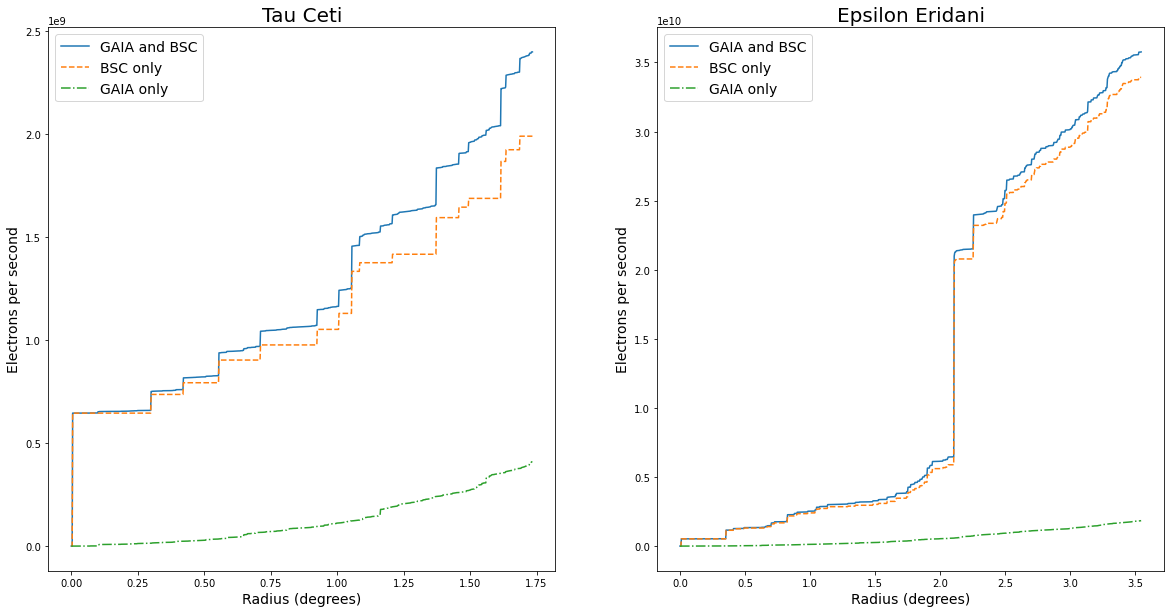

In [15]:
plt.figure(figsize = (20,10))

plt.subplot(1,2,1)
plt.plot(TC_radii*180/np.pi, TC_fluxes, label = 'GAIA and BSC')
plt.plot(TC_radii*180/np.pi, TC_fluxes_nb, label = 'BSC only', linestyle = '--')
plt.plot(TC_radii*180/np.pi, TC_fluxes-TC_fluxes_nb, label = 'GAIA only', ls = '-.')
plt.xlabel('Radius (degrees)', fontsize = 14)
plt.ylabel('Electrons per second', fontsize = 14)
plt.title('Tau Ceti', fontsize = 20)
plt.legend(fontsize = 14)

plt.subplot(1,2,2)
plt.plot(EE_radii*180/np.pi, EE_fluxes, label = 'GAIA and BSC')
plt.plot(EE_radii*180/np.pi, EE_fluxes_nb, label = 'BSC only', linestyle = '--')
plt.plot(EE_radii*180/np.pi, EE_fluxes-EE_fluxes_nb, label = 'GAIA only', ls = '-.')
plt.xlabel('Radius (degrees)', fontsize = 14)
plt.ylabel('Electrons per second', fontsize = 14)
plt.title('Epsilon Eridani', fontsize = 20)
plt.legend(fontsize = 14)



### Some Comments
The first initial spike, most visible with the $\tau$-Ceti plot, is due to the wikipedia location of the star being slightly different than in the BSC data. Also note that the y-axis is indicative only and is **not** the number of photons that would land on a detector. The units of 'electron / s' in the GAIA dataset is less than informative. I assume that it means the total energy in electron volts per second being captured by GAIA. I need to check some GAIA papers to confirm.